In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay 
from sklearn.model_selection import GridSearchCV
import time



In [3]:

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Base.csv', ',') 

# !cat /content/drive/My\ Drive/foo.txt

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#create list of categorical columns
cat_cols = df.columns[df.dtypes == 'object']
numeric_cols = df.columns[df.dtypes != 'object'].tolist()
numeric_cols.remove('fraud_bool')
numeric_cols.remove('income')


In [5]:
#split data early on 
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size=0.3, random_state=0)

Preprocess Training Set

In [11]:
# upsample minority and downsample majority
seed = 0 
cat_map = (X_train.dtypes=='object').tolist() #boolean mask of categorical columns

up = SMOTENC(cat_map[1:], sampling_strategy = 0.3, random_state=seed)
down = RandomUnderSampler(sampling_strategy=(0.3), random_state=seed) 
correct_balance = make_pipeline(up, down) #make_pipeline(up)
X_train_bal, y_train_bal = correct_balance.fit_resample(X_train.iloc[:,1:], y_train)

# encode - turn into pipeline!!!
onehotenc = OneHotEncoder(handle_unknown='ignore')
df_cat = X_train_bal[cat_cols]
matrix_cat_oh = onehotenc.fit_transform(df_cat)
df_cat_oh = pd.DataFrame(matrix_cat_oh.toarray())
X_train_encoded = pd.concat([X_train_bal[numeric_cols], df_cat_oh], axis=1)

# create final dataset 
df_train_balanced = pd.concat([y_train_bal, X_train_encoded], axis=1)


In [ ]:
X_train_bal[numeric_cols].shape

(899920, 25)

In [24]:
X_train_bal_check.head()


,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0.177561,29,15,20,0.017619,49.997895,AA,1091,9393.917154,7025.164430,...,0,500.0,0,INTERNET,4.402454,other,1,1,0,0
1,0.709171,-1,42,30,0.019877,17.660883,AA,1316,7208.680376,4213.104689,...,1,1000.0,0,INTERNET,1.199572,macintosh,1,1,0,3
2,0.930330,31,3,30,0.027754,-1.162913,AD,1190,6832.576133,5133.553364,...,0,200.0,0,INTERNET,1.402220,linux,1,1,0,7
3,0.838423,54,8,40,0.023480,-1.389747,AB,1201,1260.853428,5063.916125,...,0,1000.0,0,INTERNET,4.554860,linux,0,1,0,3
4,0.545024,-1,195,50,0.012070,-0.424996,AB,938,3450.717671,3184.971427,...,0,500.0,0,INTERNET,4.115993,other,1,1,0,7


In [ ]:
# check balance
df_train_balanced.groupby('fraud_bool')['fraud_bool'].count()/df_train_balanced.shape[0]

fraud_bool
0    0.769231
1    0.230769
Name: fraud_bool, dtype: float64

In [ ]:
# preprocess test data 
df_test_cat = X_test[cat_cols]
df_test_cat_encoded = pd.DataFrame(onehotenc.transform(df_test_cat).toarray())
X_test_numeric = X_test[numeric_cols].reset_index(drop=True)
X_test_encoded = pd.concat([X_test_numeric, df_test_cat_encoded], axis=1)


In [ ]:
#create model
clf = lgb.LGBMClassifier(objective="binary")
clf.fit(X_train_encoded, y_train_bal)
y_pred_train = clf.predict(X_train_encoded)

y_test_pred = clf.predict(X_test_encoded)


In [ ]:
#turn into function
print(accuracy_score(y_pred_train, y_train_bal))
print(balanced_accuracy_score(y_pred_train, y_train_bal))
print(classification_report(y_pred_train, y_train_bal))

all_zeros = np.zeros(len(y_train_bal), dtype='int')
print(accuracy_score(all_zeros, y_train_bal))
print(balanced_accuracy_score(all_zeros, y_train_bal))
print(classification_report(all_zeros, y_train_bal))

print(accuracy_score(y_test_pred, y_test))
print(balanced_accuracy_score(y_test_pred, y_test))
print(classification_report(y_test_pred, y_test))


0.976564583518535
0.9750139698875082
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    702372
           1       0.92      0.97      0.95    197548

    accuracy                           0.98    899920
   macro avg       0.96      0.98      0.97    899920
weighted avg       0.98      0.98      0.98    899920

0.7692305982754023


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.7692305982754023


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.77      0.87    899920
           1       0.00      0.00      0.00         0

    accuracy                           0.77    899920
   macro avg       0.50      0.38      0.43    899920
weighted avg       1.00      0.77      0.87    899920

0.9827333333333333
0.5808974307622856
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    297108
           1       0.15      0.17      0.16      2892

    accuracy                           0.98    300000
   macro avg       0.57      0.58      0.58    300000
weighted avg       0.98      0.98      0.98    300000



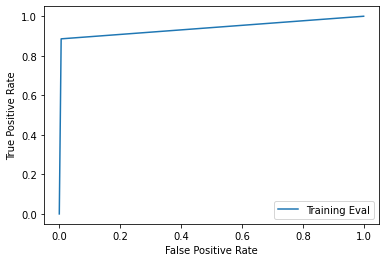

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_bal, y_pred_train)
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Training Eval').plot()

In [35]:
# create preprocessing as pipelines

full_ppl = make_pipeline(SMOTENC(cat_map[1:], sampling_strategy = 0.3, random_state=seed), 
                           RandomUnderSampler(sampling_strategy=(0.3), random_state=seed),
                           FeatureUnion(
                               transformer_list=[
                                   ("numeric", make_pipeline(
                                       ColumnTransformer(transformers=[("selectNums", 'passthrough', numeric_cols)], remainder='drop')
                                   )),
                                   ("cat", make_pipeline(
                                       ColumnTransformer(transformers=[("selectNums", 'passthrough', cat_cols)], remainder='drop'),
                                       OneHotEncoder(handle_unknown='ignore')
                                   ))
                               ]
                           ),
                         lgb.LGBMClassifier(objective="binary")
                           )

train_ppl = full_ppl.fit(X_train.iloc[:,1:], y_train)


In [ ]:
y_pred_train_ppl = full_ppl.pred(y_train)

print(accuracy_score(y_pred_train_ppl, y_train))
print(balanced_accuracy_score(y_pred_train_ppl, y_train))
print(classification_report(y_pred_train_ppl, y_train))

In [ ]:
min_gain_to_split = [0, 10, 100, 1000]
min_data_in_leaf = [10, 50, 100, 500, 1000]
learning_rate = [0.01, 0.05, 0.1]
n_estimators = [50, 100, 500, 1000]

search_params = {'min_gain_to_split': min_gain_to_split,
                 'min_data_in_leaf': min_data_in_leaf,
                 'learning_rate': 0.1,
                 'n_estimators': [1000]
                 }

gscv = GridSearchCV(clf, param_grid = {'n_estimators':n_estimators}, scoring ='balanced_accuracy', cv=5)

stime = time.time()
gscv.fit(X_train_encoded, y_train_bal)
etime = time.time()

print((etime-stime)/60)



22.618293313185372


In [ ]:
gscv.cv_results_

{'mean_fit_time': array([ 12.1318224 ,  21.70390921,  69.19207845, 124.12920594]),
 'std_fit_time': array([0.86172103, 1.94319898, 3.86500266, 8.39367486]),
 'mean_score_time': array([0.65095401, 1.18097658, 3.81405215, 8.49755378]),
 'std_score_time': array([0.03236702, 0.01605791, 0.35403982, 0.59581111]),
 'param_n_estimators': masked_array(data=[50, 100, 500, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 500},
  {'n_estimators': 1000}],
 'split0_test_score': array([0.88510269, 0.89291552, 0.90057187, 0.90386434]),
 'split1_test_score': array([0.95902728, 0.97311662, 0.98284697, 0.98701334]),
 'split2_test_score': array([0.95715296, 0.97232572, 0.98258695, 0.98666303]),
 'split3_test_score': array([0.9579571 , 0.97236785, 0.98287105, 0.98719271]),
 'split4_test_score': array([0.95825685, 0.97305763, 0.98321052, 0.98718067]),
 'mean_test_score': 

In [ ]:
gscv = GridSearchCV(clf, param_grid = {'n_estimators': [1000],
                 'learning_rate': learning_rate}, cv=5)

stime = time.time()
gscv.fit(X_train_encoded, y_train_bal)
etime = time.time()

print(f"Time taken for run: {(etime-stime)/60} minutes")


Time taken for run: 26.63393663962682 minutes


In [ ]:
gscv.cv_results_

{'mean_fit_time': array([120.12087946,  82.73181086,  76.44032588]),
 'std_fit_time': array([1.56597999, 6.25498259, 6.1738825 ]),
 'mean_score_time': array([8.13162022, 7.56036029, 6.02699509]),
 'std_score_time': array([0.10403089, 0.91574304, 0.5229034 ]),
 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[1000, 1000, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01, 'n_estimators': 1000},
  {'learning_rate': 0.05, 'n_estimators': 1000},
  {'learning_rate': 0.1, 'n_estimators': 1000}],
 'split0_test_score': array([0.93230609, 0.93513101, 0.93660768]),
 'split1_test_score': array([0.98477589, 0.98930219, 0.99081096]),
 'split2_test_score': array([0.9853215 , 0.98974351, 0.99097942]),
 'split3_test_score': array([0.98403743, 0.98880453, 0.99017688]),
 'spl

In [ ]:
gscv = GridSearchCV(clf, param_grid = {'n_estimators': [1000],
                 'learning_rate': [0.1],
                 'min_gain_to_split': min_gain_to_split,
                 'min_data_in_leaf': min_data_in_leaf
                 }, cv=5)

stime = time.time()
gscv.fit(X_train_encoded, y_train_bal)
etime = time.time()

print(f"Time taken for run: {(etime-stime)/60} minutes")


Time taken for run: 93.6096419095993 minutes


In [ ]:
gscv.cv_results_

{'mean_fit_time': array([79.19631662, 48.72630763, 43.089258  , 41.16731005, 74.8484066 ,
        47.71693254, 43.32934203, 40.4573441 , 77.7280407 , 48.44288869,
        43.48668666, 40.55918927, 82.37415504, 47.90828118, 43.48780985,
        40.79981656, 84.91617632, 48.35427103, 43.42869458, 40.39659581]),
 'std_fit_time': array([8.84196498, 1.66093191, 1.03041442, 1.29634828, 5.13331612,
        0.95092191, 1.20437489, 0.89698341, 5.61146907, 1.61391586,
        1.25575305, 0.90781958, 3.89883875, 1.08610126, 1.29811564,
        1.05935765, 1.71380344, 1.15568842, 1.12151387, 0.91329074]),
 'mean_score_time': array([5.99059453, 0.99576449, 0.55076785, 0.2819591 , 6.24039102,
        1.00617037, 0.54631314, 0.27441287, 6.10236845, 1.00352702,
        0.55804539, 0.27833533, 7.64620247, 1.07908244, 0.55124969,
        0.27400417, 7.58145514, 1.05380235, 0.55179315, 0.27524486]),
 'std_score_time': array([0.55681648, 0.07133026, 0.01153599, 0.00456411, 0.89812836,
        0.06877822, 

In [ ]:
clf_2 = lgb.LGBMClassifier(objective="binary", learning_rate = 0.1, min_gain_to_split=0, min_data_in_leaf = 50, n_estimators = 1000 )
clf_2.fit(X_train_encoded, y_train_bal)
y_pred_train_2 = clf_2.predict(X_train_encoded)

print(accuracy_score(y_pred_train_2, y_train_bal))
print(balanced_accuracy_score(y_pred_train_2, y_train_bal))
print(classification_report(y_pred_train_2, y_train_bal))

0.9873359207219007
0.9878550477435298
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    524839
           1       0.93      0.99      0.96     98183

    accuracy                           0.99    623022
   macro avg       0.97      0.99      0.98    623022
weighted avg       0.99      0.99      0.99    623022



Test Data

In [ ]:
# preprocess test data 
df_test_cat = X_test[cat_cols]
df_test_cat_encoded = pd.DataFrame(onehotenc.transform(df_test_cat).toarray())
X_test_numeric = X_test[numeric_cols].reset_index(drop=True)
X_test_encoded = pd.concat([X_test_numeric, df_test_cat_encoded], axis=1)

y_test_pred = clf.predict(X_test_encoded)
y_test_pred_2 = clf_2.predict(X_test_encoded)

print(accuracy_score(y_test_pred, y_test))
print(balanced_accuracy_score(y_test_pred, y_test))
print(classification_report(y_test_pred, y_test))

print(accuracy_score(y_test_pred_2, y_test))
print(balanced_accuracy_score(y_test_pred_2, y_test))
print(classification_report(y_test_pred_2, y_test))

0.9841633333333333
0.5891332698030164
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    297641
           1       0.14      0.19      0.16      2359

    accuracy                           0.98    300000
   macro avg       0.56      0.59      0.57    300000
weighted avg       0.99      0.98      0.99    300000

0.9857433333333333
0.6038068325436253
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    298233
           1       0.12      0.22      0.15      1767

    accuracy                           0.99    300000
   macro avg       0.56      0.60      0.57    300000
weighted avg       0.99      0.99      0.99    300000



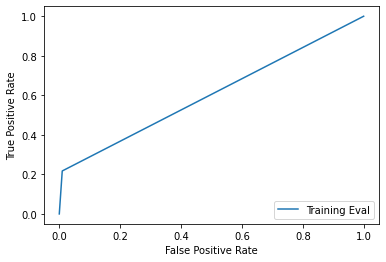

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_pred_2, y_test)
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Training Eval').plot()

In [ ]:
np.unique(y_pred)
np.unique(y_test)

array([0, 1])

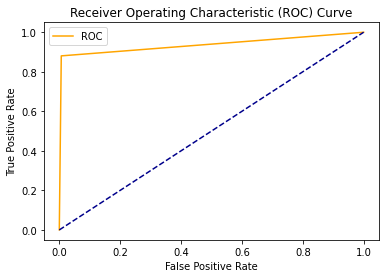

In [ ]:


fpr, tpr, thresholds = roc_curve(y_test, y_pred)

def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_cur(fpr, tpr)

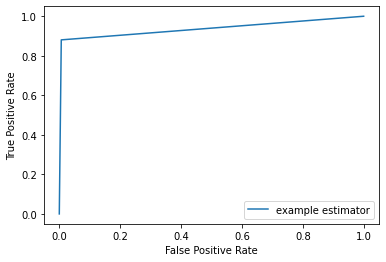

In [ ]:
from sklearn.metrics import RocCurveDisplay 
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='example estimator').plot()

In [ ]:
df_cat.iloc[:5,]

,payment_type,employment_status,housing_status,source,device_os
0,AA,CA,BA,INTERNET,windows
1,AB,CA,BA,INTERNET,windows
2,AC,CB,BA,INTERNET,other
3,AB,CA,BA,INTERNET,linux
4,AB,CA,BA,INTERNET,macintosh
